# Matching Exercise 

In this exercise, we'll be evaluating how getting a college degree impacts earnings in the US using matching.

## Matching Packages: Python v. R

Just as the best tools for machine learning tend to be in Python since they're developed by CS people (who prefer Python), most of the best tools for causal inference are implemented in R since innovation in causal inference tends to be lead by social scientists using R. As a result, the most well developed matching package is called [MatchIt](https://kosukeimai.github.io/MatchIt/index.html), and is only available in R (though you can always call it from Python using `rpy2`). 

In the last couple years, though, a group of computer scientists and statisticians here at Duke have made some great advancements in matching (especially the computational side of things), and they recently released a set of matching packages in both R and Python that we'll be using today. They have some great algorithms we'll use today, but be aware these packages aren't as mature, and aren't general purpose packages yet. So if you ever get deep into matching, be aware you will probably still want to make at least partial use of the R package [MatchIt](https://kosukeimai.github.io/MatchIt/index.html), as well as some other R packages for new innovative techniques (like [Matching Frontier estimation](https://projects.iq.harvard.edu/frontier/home)), or [Adaptive Hyper-Box Matching](https://almost-matching-exactly.github.io/AHB-R-package/). 

## Installing dame-flame. 

For this lesson, begin by installing `dame-flame` with `pip install dame-flame` (it's not on conda yet). 

[DAME](https://almost-matching-exactly.github.io/DAME-FLAME-Python-Package) is an algorithm that we can use for a version of coarse exact matching. The package only accepts a list of categorical variables, and then attempts to match pairs that match exactly on those variables. That means that if you want to match on, say, age, you have to break it up into categories (say, under 18, 18-29, 30-39, etc. etc.). 

(NOTE: As of 2024, their documentation site is weird: click the dropdowns next to headings to see the content, otherwise the documentation looks deserted)

Of course, one cannot always find exact matches on all variables, so what DAME does is:

1. Find all observations that match on *all* matching variables. 
2. Figure out which matching variable is least useful in predicting the outcome of interest $Y$ and drops that, then tries to match the remaining observations on the narrowed set of matching variables. 
3. This repeats until you run out of variables, all observations are matched, or you hit a stopping run (namely: quality of matches falls below a threshold). 

In addition, the lab has also created FLAME, which does the same thing, but employs some tricks to make it *massively* more computationally efficient, meaning it can be used on datasets with millions of observations (which most matching algorithms cannot). It's a little less accurate, but an amazing contribution never the less. 

## Data Setup

To save you some time and let you focus on matching, I've *pre-cleaned* about one month worth of of data from the US Current Population Survey data we used for our [gender discrimination analysis](exercises/exercises_regression_incomeineq.ipynb). You can download the data [from here](https://github.com/nickeubank/MIDS_Data/blob/master/Current_Population_Survey/cps_for_matching.dta?raw=true"), or read it directly with:

```python 
cps = pd.read_stata(
    "https://github.com/nickeubank/MIDS_Data/blob/master"
    "/Current_Population_Survey/cps_for_matching.dta?raw=true"
)
```

Load the data and quickly familiarize yourself with its contents. 

In [1]:
import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")
pd.set_option("mode.copy_on_write", True)

/tmp/ipykernel_62386/1807107526.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
cps = pd.read_stata(
    "https://github.com/nickeubank/MIDS_Data/blob/master"
    "/Current_Population_Survey/cps_for_matching.dta?raw=true"
)

## Getting To Know Your Data

Before you start matching, it is important to examine your data to ensure that matching is feasible (you have some overlap the the features of people in the treated and untreated groups), and also that there is a reason *to* match: either you're unsure about some of the functional forms at play, or your have some imbalance between the two groups. 

In [3]:
cps.head()

,index,annual_earnings,female,simplified_race,has_college,age,county,class94
0,151404,NaN,1,3.0,1,30,0-WV,"Private, For Profit"
1,123453,NaN,0,0.0,0,21,251-TX,"Private, For Profit"
2,187982,NaN,0,0.0,0,40,5-MA,"Self-Employed, Unincorporated"
3,122356,NaN,1,0.0,1,27,0-TN,"Private, Nonprofit"
4,210750,42900.0,1,0.0,0,52,0-IA,"Private, For Profit"


### Exercise 1

Show the raw difference of `annual_earnings` between those with and without a college degree (`has_college`). Is the difference statistically significant?

In [4]:
import statsmodels.formula.api as smf

raw_difference = smf.ols("annual_earnings ~ has_college", cps).fit()
raw_difference.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     370.2
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           6.56e-80
Time:                        21:34:57   Log-Likelihood:                -63018.
No. Observations:                5515   AIC:                         1.260e+05
Df Residuals:                    5513   BIC:                         1.261e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.887e+04    336.007    115.669      0.000    3.82e+04    3.95e+04
has_college  1.416e+04    735.820     19.242      0.000    1.27e+04    1.56e+04
==============================================================================
Omnibus:                     2214.375   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10578.287
Skew:                           1.910   Prob(JB):                         0.00
Kurtosis:                       8.608   Cond. No.                         2.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> The coefficient for `has_college` is 14,160, which indicates that having a college degree is associated with an increase in annual earnings of $14,160 on average. It is statistically significant given the p-value of 0.000

### Exercise 2

Next we can check for balance. Check the share of people in different racial groups who have college degrees. Are those differences statistically significant? (Remember how to check for difference in distributions of categorical variables).

Race is coded as White Non-Hispanic (0), Black Non-Hispanic (1), Hispanic (2), Other (3).

Does the data seem balanced?

In [5]:
import scipy.stats

In [6]:
cps.groupby("simplified_race")["has_college"].mean()

simplified_race
0.0    0.438205
1.0    0.317647
2.0    0.198413
3.0    0.474900
Name: has_college, dtype: float64

In [7]:
contingency_table = pd.crosstab(cps["simplified_race"], cps["has_college"])
contingency_table

has_college,0,1
simplified_race,,
0.0,4282,3340
1.0,696,324
2.0,1212,300
3.0,523,473


In [8]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table.values)
print(p)

1.299387594356901e-76


> The p-value is approxiamtely 1.3×10^(−76) and it's extremely close to zero. It indicates that there is a statistically significant difference in the distribution of college degrees across the different racial groups in the dataset.

### Exercise 3

One of the other advantages of matching is that even when you have balanced data, you don't have to go through the process of testing out different functional forms to see what fits the data base. 

In our last exercise, we looked at the relationship between gender and earnings "controlling for age", where we just put in age as a linear control. Plot a non-linear regression of `annual_earnings` on age (`PolyFit(order=3)` is fine.)

In [9]:
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

p = Polynomial.fit(cps['age'], cps['annual_earnings'], 3)

In [10]:
age_range = np.linspace(cps['age'].min(), cps['age'].max(), num=500)
fit = p(age_range)

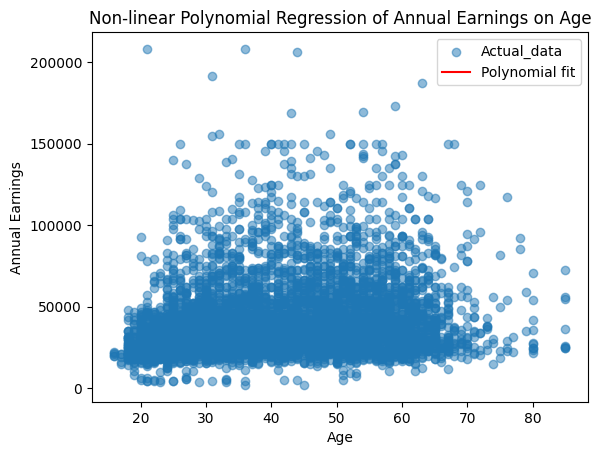

In [11]:
plt.scatter(cps['age'], cps['annual_earnings'], alpha=0.5, label='Actual_data')
plt.plot(age_range, fit, color='red', label='Polynomial fit')
plt.xlabel('Age')
plt.ylabel('Annual Earnings')
plt.title('Non-linear Polynomial Regression of Annual Earnings on Age')
plt.legend()
plt.show()

Does the relationship look linear?

Does this speak to why it's nice to not have to think about functional forms with matching as much?

> The relationship between age and annual earnings does not look linear, so the relationship is non-linear.

> This example illustrates why matching can be advantageous. It allows to compare like with like, reducing the model dependence on the inferences and possibly providing a more intuitive and straightforward comparison.

## Matching!

Because DAME is an implementation of exact matching, we have to discretize all of our continuous variables. Thankfully, in this case we only have `age`, so this shouldn't be too hard!

### Exercise 4

Create a new variable that discretizes age into a single value for each decade of age. 

Because CPS only has employment data on people 18 or over, though, include people who are 18 or 19 with the 20 year olds so that group isn't too small, and if you see any other really small groups, please merge those too. 

In [12]:
def discretize_age(age):
    if age < 20:
        return '1'
    elif 20 <= age < 30:
        return '2'
    elif 30 <= age < 40:
        return '3'
    elif 40 <= age < 50:
        return '4'
    elif 50 <= age < 60:
        return '5'
    elif 60 <= age < 70:
        return '6'
    elif 70 <= age < 80:
        return '7'
    else:
        return '8'

In [13]:
cps['discretized_age'] = cps['age'].apply(discretize_age)
cps['discretized_age'].value_counts()

discretized_age
3    2760
4    2551
5    2397
2    1866
6    1236
7     173
1     124
8      43
Name: count, dtype: int64

In [14]:
cps["discretized_age"] = cps["discretized_age"].astype(int)
print(cps["discretized_age"].dtype)

int64


In [15]:
cps.loc[cps["discretized_age"] == 1, "discretized_age"] = 2
cps.loc[cps["discretized_age"] == 8, "discretized_age"] = 7
cps["discretized_age"].value_counts()

discretized_age
3    2760
4    2551
5    2397
2    1990
6    1236
7     216
Name: count, dtype: int64

In [16]:
cps.head()

,index,annual_earnings,female,simplified_race,has_college,age,county,class94,discretized_age
0,151404,NaN,1,3.0,1,30,0-WV,"Private, For Profit",3
1,123453,NaN,0,0.0,0,21,251-TX,"Private, For Profit",2
2,187982,NaN,0,0.0,0,40,5-MA,"Self-Employed, Unincorporated",4
3,122356,NaN,1,0.0,1,27,0-TN,"Private, Nonprofit",2
4,210750,42900.0,1,0.0,0,52,0-IA,"Private, For Profit",5


### Exercise 5

We also have to covert our string variables into numeric variables for DAME, so convert `county` and `class94` to a numeric vector of intergers. 

(Note: it's not clear whether `class94` belongs: if it reflects people choosing fields based on passion, it belongs; if people choose certain jobs because of their degrees, its not something we'd actually want in our regression. 

Hint: if you use `pd.Categorical` to convert you var to a categorical, you can pull the underlying integer codes with `.codes`. 

In [17]:
cps["county"] = pd.Categorical(cps["county"]).codes
cps["class94"] = pd.Categorical(cps["class94"]).codes

## Let's Do Matching with DAME

### Exercise 6

First, drop all the variables you *don't* want in matching (e.g. your original `age` variable), and any observations for which `annual_earnings` is missing. 

You will probably also have to drop a column named `index`: DAME will try and match on ANY included variables, and so because there was a column called `index` in the data we imported, if we leave it in DAME will try (and obviously fail) to match on index. 

Also, it's best to reset your index, as `dame_flame` using index labels (e.g., the values in `df.index`) to identify matches. So you want to be sure those are unique.

In [18]:
cps.head()

,index,annual_earnings,female,simplified_race,has_college,age,county,class94,discretized_age
0,151404,NaN,1,3.0,1,30,47,3,3
1,123453,NaN,0,0.0,0,21,175,3,2
2,187982,NaN,0,0.0,0,40,226,6,4
3,122356,NaN,1,0.0,1,27,40,4,2
4,210750,42900.0,1,0.0,0,52,10,3,5


> to drop:
"annual_earnings" NaN missing values,
"age",
"index"

In [19]:
dropped_cps = cps.drop(["age", "index"], axis="columns")

In [20]:
missing_values = dropped_cps["annual_earnings"].isnull().sum()
missing_values

5635

In [21]:
dropped_cps = dropped_cps.dropna(subset=['annual_earnings'])
dropped_cps

,annual_earnings,female,simplified_race,has_college,county,class94,discretized_age
4,42900.0,1,0.0,0,10,3,5
5,31200.0,0,2.0,0,31,3,3
7,20020.0,0,0.0,1,8,3,6
8,22859.2,0,0.0,0,44,1,4
9,73860.8,0,0.0,1,24,3,3
...,...,...,...,...,...,...,...
11142,33800.0,1,3.0,0,247,3,3
11143,23920.0,0,3.0,0,272,3,5
11144,31200.0,0,2.0,0,246,3,2
11145,37440.0,0,0.0,0,99,3,2


### Exercise 7

The syntax of `dame_flame` is similar to the syntax of `sklearn`. If you start with a dataset called `my_data` with a `treat` variable with treatment assignment and an `outcome` variable for my outcome of interest ($Y$), the syntax to do basic matching would be:

```python
import dame_flame
model = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
)
model.fit(
    for_matching,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)
result = model.predict(for_matching)
```

Where the arguments:

- `repeats=False` says that I only want each observation to get matched once. We'll talk about what happens if we use `repeats=True` below. 
- `verbose=3` tells dame to report everything it's doing as it goes. 
- `want_pe` says "please include the predictive error in your printout at each step". This is a measure of match quality. 
- `stop_unmatched_t` says "once you've matched all the treatment units, you can stop."

So run DAME on your data!

In [22]:
import dame_flame
model = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
)
model.fit(
    dropped_cps,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)
result = model.predict(dropped_cps)

Completed iteration 0 of matching
	Number of matched groups formed in total:  370
	Unmatched treated units:  644 out of a total of  1150 treated units
	Unmatched control units:  3187 out of a total of  4365 control units
	Number of matches made this iteration:  1684
	Number of matches made so far:  1684
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  1199312680.0957856
Completed iteration 1 of matching
	Number of matched groups formed in total:  494
	Unmatched treated units:  25 out of a total of  1150 treated units
	Unmatched control units:  180 out of a total of  4365 control units
	Number of matches made this iteration:  3626
	Number of matches made so far:  5310
	Covariates dropped so far:  frozenset({'county'})
	Predictive error of covariate set used to match:  1199421883.1095908
Completed iteration 2 of matching
	Number of matched groups formed in total:  494
	Unmatched treated units:  25 out of a total of  1150 treated units
	Unmatched contr

## Interpreting DAME output

The output you get from doing this *should* be reports from about 8 iterations of matching. In each iteration, you'll see a description of the number of matches made in the iteration, the number of treatment units still unmatched, and the number of control units unmatched. 

In the first iteration, the algorithm tries to match observations that match on *all* the variables in your data. That's why in the first iteration, you see the set of variables being dropped is an empty set (`Covariates dropped so far: set()`) — it *hasn't* dropped any variables:

```
Completed iteration 0 of matching
	Number of matched groups formed in total:  370
	Unmatched treated units:  644 out of a total of  1150 treated units
	Unmatched control units:  3187 out of a total of  4365 control units
	Number of matches made this iteration:  1684
	Number of matches made so far:  1684
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  1199312680.0957854

```

(Note depending on how you binned ages, you may get slightly different results than this)

But as we can see from this output, the algorithm found 1,684 perfect matches—pairs of observations (one treated, one untreated) that had *exactly* the same value of all the variables we included. But we also see we still have 644 *unmatched* treated units, so what do we do?


The answer is that if we want to match more of our treatment variables, we have to try and match on a subset of our variables.

But what variable should we drop? This is the secret sauce of DAME. DAME picks the variables to drop by trying to predict our outcome $Y$ using all our variables (by default using a ridge regression), then it drops the matching variable that is contributing the least to that prediction. Since our goal in matching is to eliminate baseline differences ($E(Y_0|D=1) - E(Y_1|D=0)$), dropping the covariates least related to $Y$ makes sense.

As a result, in the second iteration (called iteration 1, since it uses 0-based indexing), we see that the variable it drops first is `county`, and it's subsequently able to make another 3,626 new matches on the remaining variables!

```
Completed iteration 1 of matching
	Number of matched groups formed in total:  494
	Unmatched treated units:  25 out of a total of  1150 treated units
	Unmatched control units:  180 out of a total of  4365 control units
	Number of matches made this iteration:  3626
	Number of matches made so far:  5310
	Covariates dropped so far:  frozenset({'county'})
	Predictive error of covariate set used to match:  1199421883.1095908

```

And so DAME continues until its matched all treated observations, and even then it keeps going to evaluate different covariates it might exclude.

## Exercise 8

Congratulations! You just on your first one-to-many matching! 

The next step is to think about which of the matches that DAME generated are good enough for inclusion in our analysis. As you may recall, one of the choices you have to make as a researcher when doing matching is how "good" a match has to be in order to be included in your final data set. By default, DAME will keep dropping matching variables until it has been able to match all the treated observations or runs out of variables. It will do this no matter how bad the matches start to become -- if it ends up with the treated observation and a control observation that can only be matched on gender, it will match them just on gender, even though we probably don't think that that's a "good" match.

The way to control this behavior is to tell DAME when to stop manually using the `early_stop_iterations` argument to tell the matching algorithm when to stop.

So when is a good time to stop? There's no objective or "right" answer to that question. It fundamentally comes down to a trade-off between bias (which gets higher is you allow more low quality matches into your data) and variance (which will go down as you increase the number of matches you keep).

But one way to start the process of picking a cut point is to examine how the quality of matches evolves over iterations. DAME keeps this information in `model.pe_each_iter`. This shows, for each iteration, the "prediction error" resulting from dropping the variables excluded in each step. This "prediction error" is the difference in the mean-squared error of regressing $Y$ on our matching variables (by default in a ridge regression) with all variables versus with the subset being used for matching in a given iteration. By design, of course, this is always increasing. 

To see how this evolves, plot your `pe` against iteration numbers. You can also see the `pe` values for each iteration reported in the output from when DAME ran above if you want to make your you're lining up the errors with iterations right. 

Are there any points where the match quality seems to fall off dramatically? 

In [32]:
pe_each_iter = model.pe_each_iter

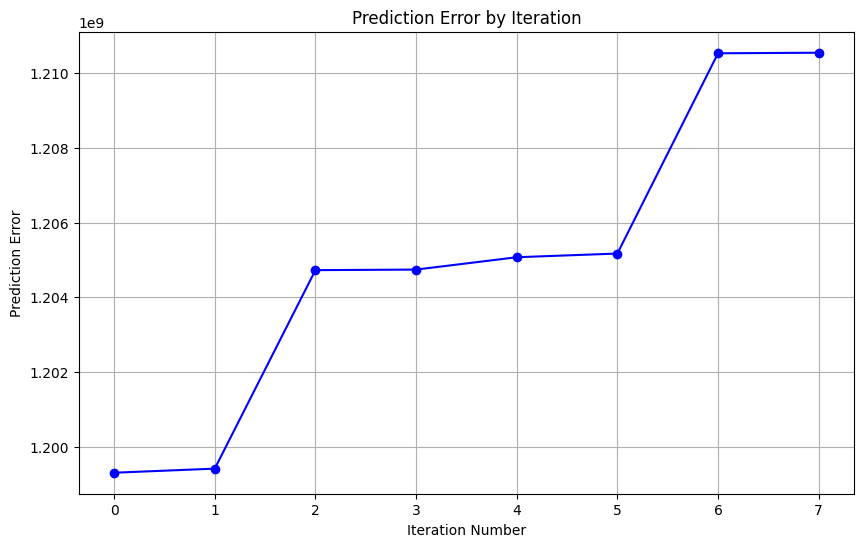

In [33]:
iterations = list(range(0, len(pe_each_iter)))

plt.figure(figsize=(10,6))
plt.plot(iterations, pe_each_iter, marker='o', linestyle='-', color='b')
plt.title('Prediction Error by Iteration')
plt.xlabel('Iteration Number')
plt.ylabel('Prediction Error')
plt.grid(True)
plt.show()

> It looks like the match quality fall off dramatically starting at point 2 and then at 6.

### Exercise 9

Suppose we want to ensure we have at least 5,000 observations in our matched data—where might you cut off the data to get a sample size of at least that but before a big quality falloff?

> Since quality falls off dramatically between points 1 and 2, we would cut off after interation point #1 at the graph.

### Exercise 10

Re-run your matching, stopping at the point you picked above using `early_stop_iterations`.

In [34]:
ex10 = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
    early_stop_iterations=1
)

ex10.fit(
    dropped_cps,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)

ex10_result = ex10.predict(dropped_cps)

Completed iteration 0 of matching
	Number of matched groups formed in total:  370
	Unmatched treated units:  644 out of a total of  1150 treated units
	Unmatched control units:  3187 out of a total of  4365 control units
	Number of matches made this iteration:  1684
	Number of matches made so far:  1684
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  1199312680.0957856
Completed iteration 1 of matching
	Number of matched groups formed in total:  494
	Unmatched treated units:  25 out of a total of  1150 treated units
	Unmatched control units:  180 out of a total of  4365 control units
	Number of matches made this iteration:  3626
	Number of matches made so far:  5310
	Covariates dropped so far:  frozenset({'county'})
	Predictive error of covariate set used to match:  1199421883.1095908
5310 units matched. We stopped after iteration 1


## Getting Back a Dataset

OK, my one current complaint with DAME is that it doesn't just give you back a nice dataset of your matches for analysis. If we look at our results — `matches` — it's *almost* what we want, except it has dropped our treatment and outcome columns, and put a string `*` in any entry where a value *wasn't* used for matching:

```
  female simplified_race   county   class94   discretized_age
0  1.0     0.0              10.0      3.0          5.0
1  0.0     2.0              *         3.0          3.0
2  0.0     0.0              8.0        3.0         6.0
3  0.0     0.0              *         1.0          4.0
4  0.0     0.0              24.0      3.0          3.0
```

So for now (though I think this will get updated in the package), we'll have to do it ourselves! Just copy-paste this:

```python

def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

```



### Exercise 11

Copy-paste that code and run it with your original data, your (fit) model, and what you got back when you ran `result_of_fit`. Then we'll work with the output of that. You should get back a single dataframe of the same length as your original model.

## Check Your Matches and Analyze

### Exercise 12

We previously tested balance on `simplified_race` and `county`. Check those again. Are there still statistically significant differences in college education by `simplified_race`?

Note that when you test for this, you'll need to take into account the `weights` column you got back from `get_dataframe`. What DAME does is not actually the 1-to-1 matching described in our readings — instead, however many observations that exact match it finds it puts in the same "group". (These groups are identified in the dataframe you got from `get_dataframe` by the column `match_group`, and the size of each group is in `match_group_size`.)

So to analyze the data, you need to use the `wls` (weighted least squares) function in `statsmodels`. For example, if your data is called `matched_data`, you might run:

```python
smf.wls(
    "has_college ~ C(simplified_race)", matched_data, weights=matched_data["weights"]
).fit().summary()
```


### Exercise 13

Now use a weighted least squares regression on your matched data to regress annual earnings on *just* having a college eduction. What is the apparent effect of a BA? How does that compare to our initial estimate using the raw CPS data (before matching)?

### Exercise 14

Now include our other matching variables as controls (e.g. all the coefficients you gave to DAME to use). Does the coefficient change?

### Exercise 15

If you stopped matching after the second iteration (Iteration 1) back in Exercise 10, you may be wondering if that was a good choice! Let's check by restricting our attention to ONLY exact matches (`iteration = 0`). Run that match.


### Exercise 16

Now use a weighted linear regression on your matched data to regress annual earnings on *just* having a college eduction. Is that different from what you had when you allowed more low quality matches?

## Other Forms of Matching

OK, hopefully this gives you a taste of matching! There are, of course, *many* other permutations to be aware of though. 

- Matching with replacement.  In this exercise, we set `repeat=False`, so each observation could only end up in our final dataset once. However, if we use `repeat=True`, if an untreated observation is the closest observation to multiple treated observations, it may get put in the dataset multiple times. We can still use this dataset in *almost* the same way, though, except we have to make use of weights so that if an observation appears, say, twice, each observation has a weight that's 1/2 the weight of an observation only appearing once. 
- Matching with continuous variables: DAME is used for exact matching, but if you have lots of continuous variables, you can also match on those. In fact, the Almost Exact Matching Lab also has a library called [MALTS](https://almost-matching-exactly.github.io/MALTS/) that will do matching with continuous variables. That package does something *like* Mahalanobis Distance matching, but ulike Mahalanobis, which calculates the distance between observations in terms of the difference in all the matching variables normalized by each matching variable's standard deviation, MALTS does something much more clever. (Here's [the paper](https://arxiv.org/abs/1811.07415) describing the technique if you want all the details). Basically, it figures out how well each matching variable predicts our outcome $Y$, then weights the different variables by their predictive power instead of just normalizing by something arbitrary like their standard deviation. As a result, final matches will prioritize matching more closely on variables that are outcome-relevant. In addition, when it sees a categorical variable, it recognizes that and only pairs observations when they are an exact match on that categorical variable. 
- If you're dataset is huge, use `FLAME`: this dataset is small, but if you have lots of observations and lots of matching variable, the computational complexity of this task explodes, so the AEML created FLAME, which works with millions of observations at only a small cost to match quality. 